In [32]:
import numpy as np
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import *
import json

In [33]:
class VQA:

    def __init__(self, qubits, shots):
        self.qubits = qubits
        self.shots = shots

class VQSD(VQA):

    def __init__(self, qubits, shots):
        super().__init__(qubits, shots)
        #self.depth = depth

    def run(self, param = None):
        #if param == None:
        #    param = []
        #    d = 1
        #    L = self.qubits + 2*(self.qubits - 1)*d
        #    for i in range(L):
        #        param.append(i)
        #print(param)
        
        def test_prep(param):
            for i in range(2*self.qubits):
                qml.Hadamard(i)
        
        def cost_cirq(param):
            for i in range(self.qubits):
                qml.CNOT(wires = [i,i+self.qubits])


        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def initial_layer(param, q):
            for i in range(self.qubits):
                rot(param[i], i+q)

        def rot_ent(param, i, j):
            qml.CNOT(wires = [i, i+1])
            rot(param[j], i)
            rot(param[j+1], i+1)

        def rot_block(param, q):
            e = []
            o = []
            for i in range(self.qubits - 1):
                if i % 2 == 0:
                    e.append(i)
                    rot_ent(param, i + q, self.qubits + i)
                else:
                    o.append(i)
                
            for k in range(len(o)):
                rot_ent(param, o[k] + q, self.qubits + e[-1] + 2*(k+1))

        def Ansatz_block(param, q):
            initial_layer(param, q)
            rot_block(param, q)
            
        def Ansatz(param):
            Ansatz_block(param, 0)
            Ansatz_block(param, self.qubits)

        def Error(param, p):
            for i in range(2*self.qubits):
                qml.BitFlip(p, wires = i)

        dev = qml.device("default.mixed", wires = 2*self.qubits, shots = self.shots)
        @qml.qnode(dev, interface="autograd")
        def vqsd(param):
            test_prep(param)
            Ansatz(param)
            cost_cirq(param)
            #Error(param, 0.05)
            return qml.probs(wires = [i for i in range(self.qubits, 2*self.qubits)])

        #drawer = qml.draw(vqsd)
        #print(drawer((param)))
        #print(drawer((param)), end='\r')

        def output(param):
            return 1-vqsd(param)[0] 

        return (output(param))
#
    def eval_readout(self, param = None):
        #if param == None:
        #    param = []
        #    d = 1
        #    L = self.qubits + 2*(self.qubits - 1)*d
        #    for i in range(L):
        #        param.append(1.57)

        def opt_test_prep(param):
            for i in range(self.qubits):
                qml.Hadamard(i)
                
        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def initial_layer(param, q):
            for i in range(self.qubits):
                rot(param[i], i+q)

        def rot_ent(param, i, j):
            qml.CNOT(wires = [i, i+1])
            rot(param[j], i)
            rot(param[j+1], i+1)

        def rot_block(param, q):
            e = []
            o = []
            for i in range(self.qubits - 1):
                if i % 2 == 0:
                    e.append(i)
                    rot_ent(param, i + q, self.qubits + i)
                else:
                    o.append(i)
                
            for k in range(len(o)):
                rot_ent(param, o[k] + q, self.qubits + e[-1] + 2*(k+1))

        def Ansatz_block(param, q):
            initial_layer(param, q)
            rot_block(param, q)
            
        def Ansatz(param):
            Ansatz_block(param, 0)
            Ansatz_block(param, self.qubits)

        def Error(param, p):
            for i in range(self.qubits):
                qml.BitFlip(p, wires = i)

        dev2 = qml.device("default.mixed", wires = self.qubits, shots = self.shots)
        @qml.qnode(dev2, interface = "autograd")
        def eval_read(param):
            opt_test_prep(param)
            Ansatz_block(param, 0)
            #Error(param, 0.05)
            return qml.probs()

        return (eval_read(param))

    def opt(self, step, theta = None):
        if theta == None:
            theta = 0
            angle = []
            t = []
            d = 1
            L = self.qubits + 2*(self.qubits - 1)*d
            for i in range(L):
                t.append(2*(np.pi)*(np.random.uniform()))
            theta = np.array(t, requires_grad=True)
            angle = [theta]

        else:
            angle = theta
        
        error = []
        diag = []
        Ev = []
        system_size = 2*self.qubits

        diag = [self.run(theta)]
        Ev = [self.eval_readout(theta)]

        opt = qml.GradientDescentOptimizer(stepsize=step)
        #try ADAM
        max_iterations = 1000000000
        max_time = 18000
        conv_tol = 1.6e-03
        start_time = time.time()
        

        print("\n" f"initial value of the circuit parameter = {angle[0]}")

        for n in range(max_iterations):
            theta, prev_diag = opt.step_and_cost(self.run, theta)

            diag.append(self.run(theta))
            angle.append(theta)
            Ev = np.vstack((Ev, self.eval_readout(theta)))
            conv = 1 - max(Ev[-1,:])
            error.append(conv.numpy())       
            Time = time.time() - start_time  

            if n % 10 == 0:
                print(f"Step = {n},  Diagonality = {diag[-1]:.8f}, Eigen_Values = {Ev[-1]}")
            
            #if n == max_iterations:
            #    print("\n"f"Max iterations = {max_iterations}")
            #    break

            if Time >= max_time:
                print("\n"f"Max iterations = {n}")
                break

            if round(conv.item(), 3) <= conv_tol:
                max_iterations = n
                print("\n"f"Max iterations = {n}")
                print(f"The max eigenvalue is {max(Ev[-1,:])}")
                print(f"The convergence is {conv}")
                print(f"The eigenvalue error is {round(conv.item(), 3)}")
                break
        
        Time = time.time() - start_time

        print("\n" f"Optimization runtime = {Time}s")
        print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
        print("\n" f"Eigenvalues are: {Ev[-1,:]}")

        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(12)
        
        

        data = {
            "n_qubits": system_size, 
            "cost_history": diag, 
            "error_history": str(error),
            "ansatz": f"Single Layer Simplified 2-Design",
            "cost": f"Global",
            "optimizer": f"{opt}",
            "step size": step,
            "error_threshold": conv_tol,
            "noise_model": 'none',
            "Time to Solution": Time,
            "Iterations to Solution": max_iterations,
            "Final Error": str(conv),
            "Optimal_weights": str(angle[-1]),
            "Initial_weights": str(angle[0])
            }
        
        #list(data)

        with open(f"Plus_{self.qubits}_qubits.json", 'w') as outfile:
            json.dump(data, outfile)

        #print(data)
        #with open(f'data_toy_{self.qubits}.json', 'a') as fp:
        #    fp.write(",")
        #    json.dump(data, fp)

        #if save == True:
        #    filename='VQSD_'+'{self.qubits}'+'noise_model.json'
        #    script_path = os.path.abspath(__file__)
            #save_path = script_path.replace()
        #    completename = os.path,join(script_path, filename)

        #    with open(completename, 'wb') as file:
        #        pickle.dump(data, file) 

        plt.plot(range(len(diag)), diag, "k", ls = "solid")
        for i in range(len(Ev[n,:])):
            plt.plot(range(len(diag)), Ev[:,i], 'r', ls="dashed")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

        #return(data)


initial value of the circuit parameter = [0.92332471]
Step = 0,  Diagonality = 0.20000000, Eigen_Values = [0.83 0.17]
Step = 10,  Diagonality = 0.17000000, Eigen_Values = [0.93 0.07]
Step = 20,  Diagonality = 0.10000000, Eigen_Values = [0.93 0.07]
Step = 30,  Diagonality = 0.08000000, Eigen_Values = [0.96 0.04]
Step = 40,  Diagonality = 0.05000000, Eigen_Values = [0.96 0.04]
Step = 50,  Diagonality = 0.07000000, Eigen_Values = [0.97 0.03]
Step = 60,  Diagonality = 0.08000000, Eigen_Values = [0.95 0.05]
Step = 70,  Diagonality = 0.07000000, Eigen_Values = [0.94 0.06]
Step = 80,  Diagonality = 0.11000000, Eigen_Values = [0.97 0.03]
Step = 90,  Diagonality = 0.04000000, Eigen_Values = [0.94 0.06]
Step = 100,  Diagonality = 0.11000000, Eigen_Values = [0.93 0.07]
Step = 110,  Diagonality = 0.09000000, Eigen_Values = [0.98 0.02]
Step = 120,  Diagonality = 0.09000000, Eigen_Values = [0.9 0.1]
Step = 130,  Diagonality = 0.09000000, Eigen_Values = [0.93 0.07]
Step = 140,  Diagonality = 0.17000

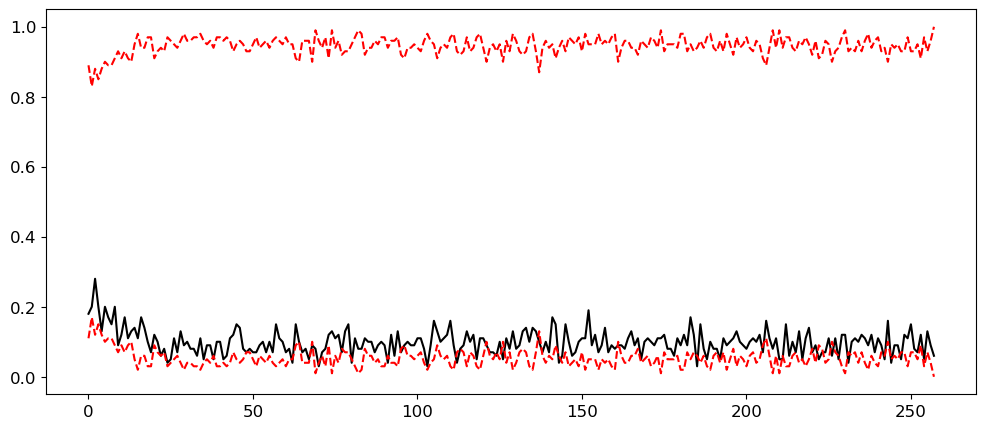

In [16]:
z = VQSD(1, 100)
z.opt(0.1)


initial value of the circuit parameter = [4.69535036 6.11819601 3.85731561 5.62619286]
Step = 0,  Diagonality = 0.65000000, Eigen_Values = [0.06 0.4  0.11 0.43]
Step = 10,  Diagonality = 0.51000000, Eigen_Values = [0.02 0.5  0.04 0.44]
Step = 20,  Diagonality = 0.54000000, Eigen_Values = [0.   0.59 0.01 0.4 ]
Step = 30,  Diagonality = 0.50000000, Eigen_Values = [0.  0.6 0.  0.4]
Step = 40,  Diagonality = 0.42000000, Eigen_Values = [0.   0.75 0.   0.25]
Step = 50,  Diagonality = 0.05000000, Eigen_Values = [0.   0.99 0.   0.01]

Max iterations = 51
The max eigenvalue is 1.0
The convergence is 0.0
The eigenvalue error is 0.0

Optimization runtime = 11.59837293624878s

Optimal value of the circuit parameter = [3.33735036 6.30119601 4.53531561 4.71919286]

Eigenvalues are: [0. 1. 0. 0.]


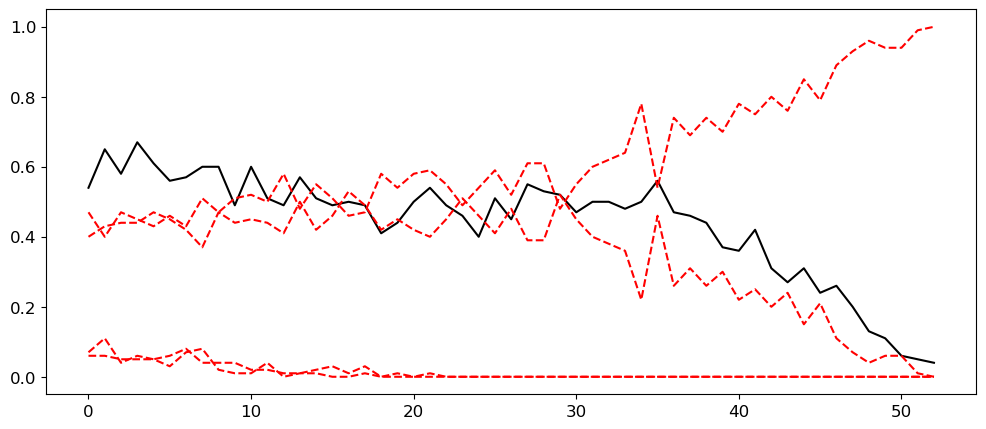

In [34]:
b = VQSD(2,100)
b.opt(0.2)


initial value of the circuit parameter = [0.58274963 0.24720687 3.06392877 2.01531148 5.42472352 5.81187522
 4.76414046]
Step = 0,  Diagonality = 0.54000000, Eigen_Values = [0.61 0.02 0.24 0.01 0.09 0.   0.03 0.  ]
Step = 10,  Diagonality = 0.19000000, Eigen_Values = [0.85 0.03 0.05 0.   0.06 0.01 0.   0.  ]
Step = 20,  Diagonality = 0.19000000, Eigen_Values = [0.94 0.01 0.03 0.   0.02 0.   0.   0.  ]
Step = 30,  Diagonality = 0.15000000, Eigen_Values = [0.86 0.06 0.01 0.   0.05 0.   0.02 0.  ]
Step = 40,  Diagonality = 0.23000000, Eigen_Values = [0.9  0.05 0.   0.   0.04 0.01 0.   0.  ]
Step = 50,  Diagonality = 0.13000000, Eigen_Values = [0.86 0.04 0.05 0.   0.05 0.   0.   0.  ]
Step = 60,  Diagonality = 0.11000000, Eigen_Values = [0.88 0.05 0.04 0.   0.03 0.   0.   0.  ]
Step = 70,  Diagonality = 0.14000000, Eigen_Values = [0.88 0.05 0.03 0.01 0.03 0.   0.   0.  ]
Step = 80,  Diagonality = 0.12000000, Eigen_Values = [0.82 0.06 0.05 0.   0.06 0.01 0.   0.  ]
Step = 90,  Diagonality 

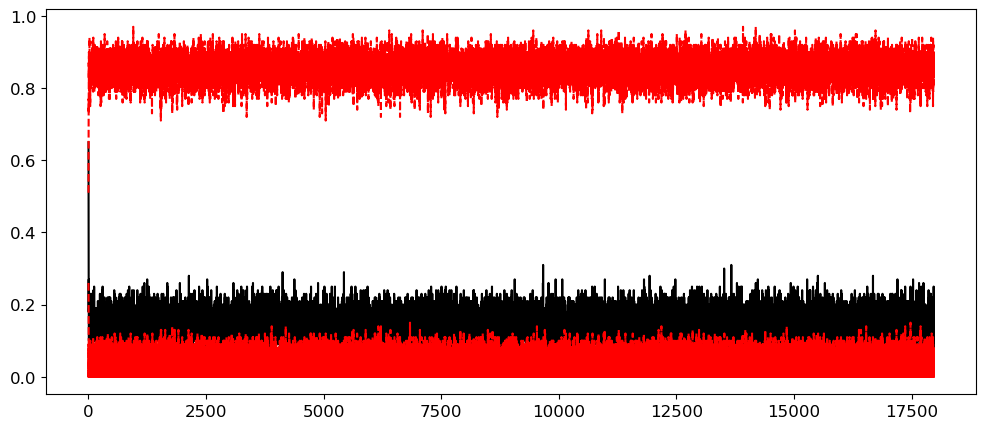

In [31]:
c = VQSD(3,100)
c.opt(0.7)


initial value of the circuit parameter = [3.4779444  1.46496787 5.13944429 4.23379897 0.39780514 3.39516006
 5.43660487 1.89685757 1.20447325 5.07553549]
Step = 0,  Diagonality = 0.87000000, Eigen_Values = [0.01 0.03 0.06 0.07 0.01 0.07 0.03 0.03 0.08 0.25 0.   0.02 0.05 0.07
 0.06 0.16]
Step = 10,  Diagonality = 0.65000000, Eigen_Values = [0.   0.02 0.   0.05 0.01 0.24 0.01 0.01 0.   0.45 0.   0.07 0.   0.07
 0.   0.07]
Step = 20,  Diagonality = 0.25000000, Eigen_Values = [0.   0.06 0.   0.   0.   0.01 0.   0.   0.04 0.76 0.02 0.02 0.   0.09
 0.   0.  ]
Step = 30,  Diagonality = 0.29000000, Eigen_Values = [0.   0.05 0.   0.   0.   0.   0.   0.   0.04 0.84 0.   0.04 0.01 0.02
 0.   0.  ]
Step = 40,  Diagonality = 0.25000000, Eigen_Values = [0.   0.04 0.   0.   0.   0.   0.   0.   0.05 0.82 0.   0.04 0.   0.04
 0.   0.01]
Step = 50,  Diagonality = 0.21000000, Eigen_Values = [0.01 0.07 0.   0.   0.   0.   0.   0.   0.05 0.76 0.   0.05 0.   0.06
 0.   0.  ]
Step = 60,  Diagonality = 0.19

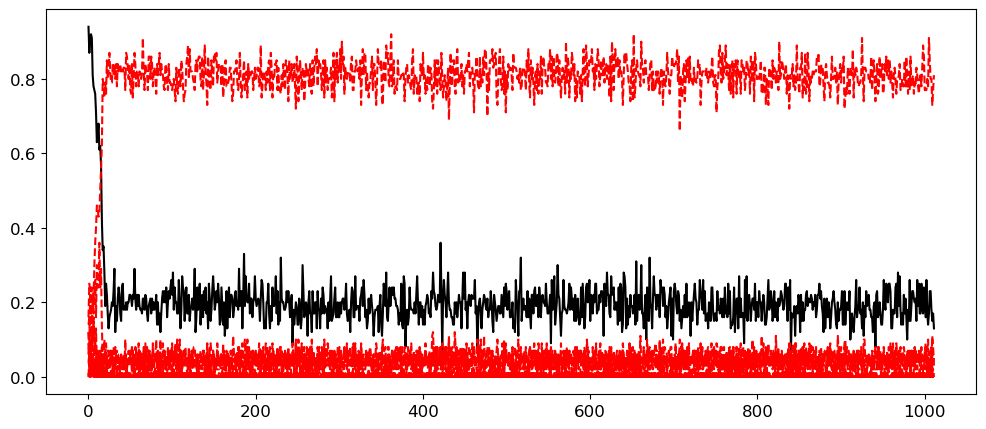

In [27]:
c = VQSD(4,100)
c.opt(0.9)


initial value of the circuit parameter = [5.52845309 1.01590521 6.07427261 2.61177099 5.86625838 3.42699796
 2.69662917 3.27734667 0.04606661 4.65377783 2.70701824 2.69868231
 4.66101909 4.33293445 5.19090039 5.06286253 3.5881068  5.97983548
 0.45724277 4.05568432 4.76821926 0.08685475]
Step = 0,  Diagonality = 0.98000000, Eigen_Values = [0.   0.   0.02 0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.
 0.01 0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.
 0.02 0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.02 0.
 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.01 0.
 0.02 0.   0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.01 0.
 0.   0.   0.01 0.   0.02 0.   0.   0.   0.02 0.   0.   0.   0.02 0.
 0.   0.   0.04 0.   0.01 0.01 0.01 0.   0.   0.   0.02 0.   0.01 0.
 0.03 0.   0.   0.   0.   0.   0.   0.

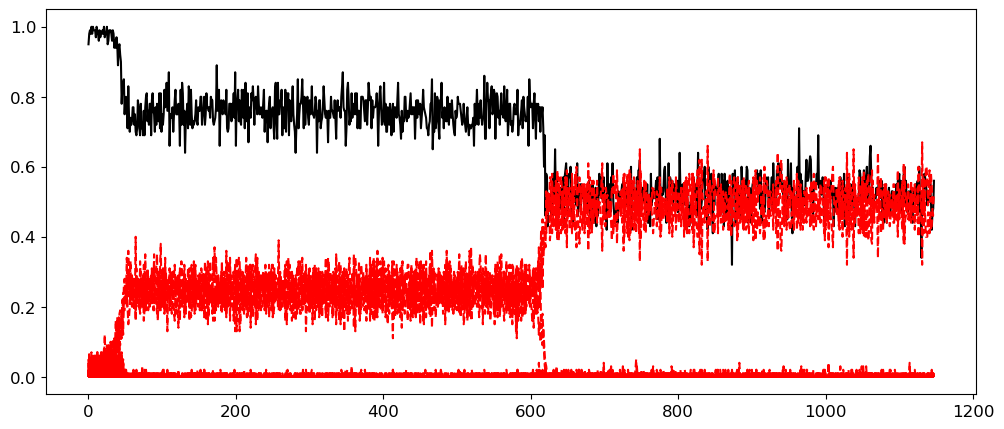

In [4]:
b = VQSD(8,100)
b.opt(1.5)


initial value of the circuit parameter = [0.78781997 1.64326253 0.15610231 0.60661132 1.30452925 5.61331162
 3.49141882 3.75623219 4.94774409 1.68905947 5.86832576 2.49807811
 5.65744144 5.33079389 2.3189264  5.96667499 1.31348382 0.97515235
 5.10064762 2.56028258 2.76609686 2.91928877 2.30427828 0.67065089
 3.96570686]
Step = 0,  Diagonality = 1.00000000, Eigen_Values = [0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.04 0.   0.01 0.02
 0.   0.01 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.02 0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.02 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

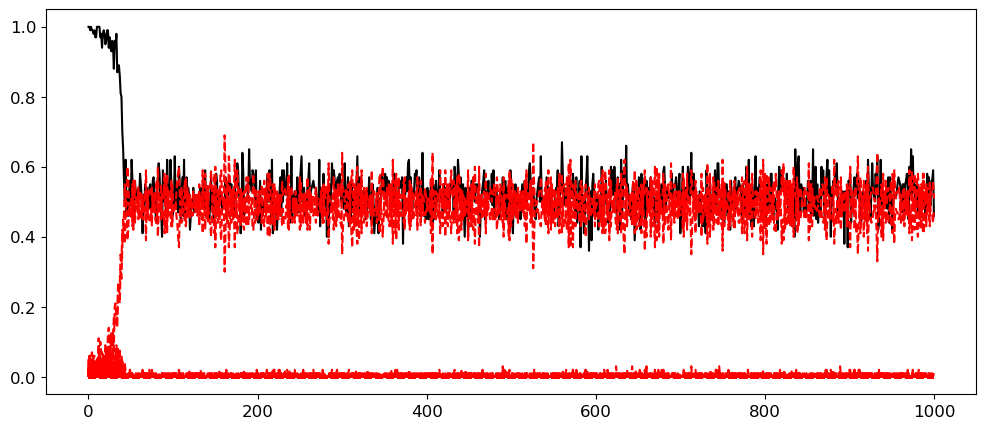

In [84]:
b = VQSD(9,100)
b.opt(1.2)